# Idealized Case 2: Splitting and Merging of two Blobs in 2D

This notebook is a demonstration of how tobac can be used to handle merging and splitting of features in the linking process.

In [184]:
import tobac
import numpy as np
import matplotlib.pyplot as plt

import datetime
import xarray as xr

We will use an artificial Dataset in this tutorial, for which we need two functions:
- The first to create an numpy array of a gaussian blob wandering with a constant velocity:

In [185]:
def wandering_blob(x_0, y_0, x_min, y_min, x_max, y_max, v_x, v_y, t_max):
    
    x = np.linspace(x_min, x_max, 50)
    y = np.linspace(y_min, y_max, 50)
    t = np.linspace(0, t_max, 20)
    tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

    exponent = (xx - x_0 - v_x*tt)**2 + (yy - y_0 - v_y*tt)**2
    
    blob = np.exp(-exponent)
    
    return blob

- The second one the transform it into a xarray:

In [186]:
def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    x = np.linspace(0, 10, 50)
    y = np.linspace(0, 10, 50)
    latitude = np.linspace(20, 30, 50)
    longitude = np.linspace(40, 50, 50)
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y}
    
    attributes = {'units': 'm s-1'}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

Adding two of the blobs will create simple case of merging and splitting.

In [187]:
blob = wandering_blob(0, 0, 0, 0, 10, 10, 1, 1, 10) + wandering_blob(10, 0, 0, 0, 10, 10, -1, 1, 10)
data = create_xarray(blob)

It is not neccesary to understand these functions, it is sufficient to look at the result:

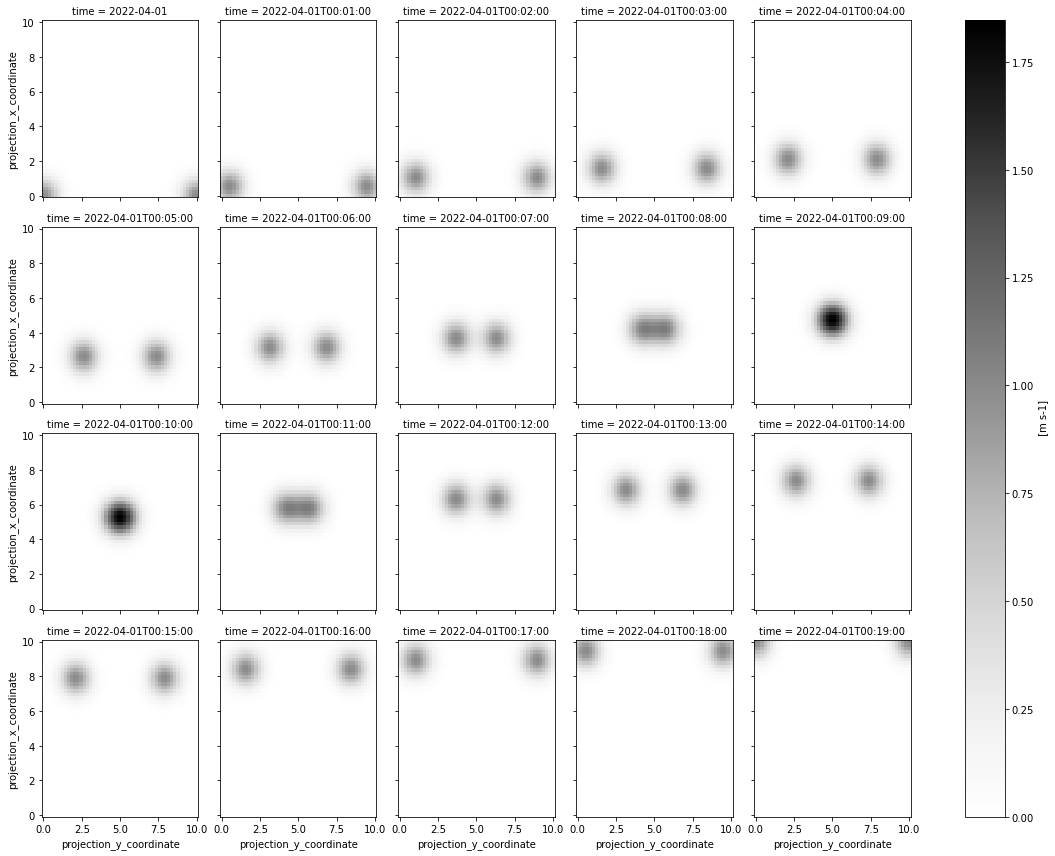

In [188]:
%matplotlib inline

data.plot(cmap = 'Greys', col='time', col_wrap=5)

Applying feature detetcion will reveal the problem for tobac with this dataset. As you can see there are certain frames where the two blobs overlap for the most part, so that only one feature is detected. We can now use the segmentation to to make this even clearer.

In [189]:
%%capture
dxy, dt = tobac.utils.get_spacings(data, grid_spacing = 1)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.5)
mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.5)

Text(0.5, 1.0, 'segments before, during and after merge/split')

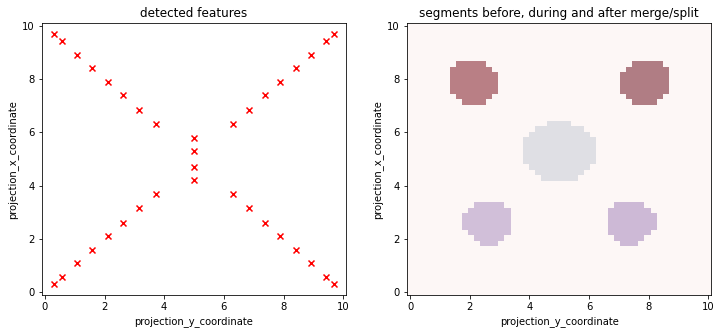

In [190]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))

data[10].plot(ax=ax[0], cmap = 'Greys', add_colorbar=False, alpha = 0)
features.plot.scatter(
        x="projection_y_coordinate",
        y="projection_x_coordinate",
        ax=ax[0],
        color="red",
        marker="x"
)
ax[0].set_title('detected features')
data[10].plot(ax=ax[1], cmap = 'Greys', add_colorbar=False, alpha = 0)
    
mask[10].plot(ax = ax[1], alpha = 0.5, add_colorbar=False, cmap='Blues')
mask[5].plot(ax = ax[1], alpha = 0.5, add_colorbar=False, cmap='Purples')
mask[15].plot(ax = ax[1], alpha = 0.5, add_colorbar=False, cmap='Reds')

ax[1].set_title('segments before, during and after merge/split')

For actually measured data the probabilties for two features to overlap exactly is of course low, but it can be interesting to look at such an edgecases. The question is now how the tracking will look like for this case. So let's try it:

In [191]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max = 1e20)

Frame 19: 2 trajectories present.


Text(0.5, 1.0, 'tracked cells')

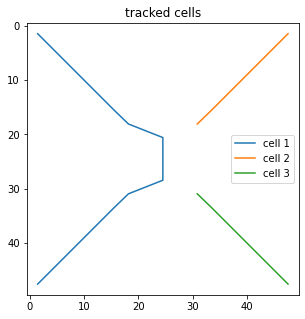

In [192]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (5, 5))

plt.imshow(blob[10], cmap = 'Greys', alpha = 0)

for i, track_i in track.groupby('cell'):
    plt.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)))
ax.legend()
ax.set_title('tracked cells')

This way of linking the features might be the obvioust way to do it for you, but it is certainly not the only way. Let's perform the process of linking multiple times and check wether this is the only way tobac finds to link the features:

Frame 19: 2 trajectories present.


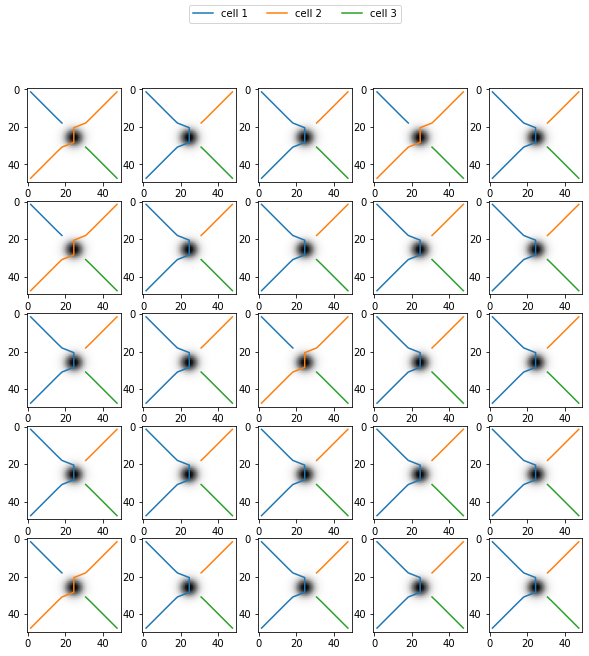

In [193]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))

for j, axes in enumerate(ax.flatten()):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max = 1e3, method_linking='random')

    axes.imshow(blob[10], cmap = 'Greys')

    for i, track_i in track.groupby('cell'):
        
        if j == 0:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'],
                      label = 'cell {0}'.format(int(i)))
            
        else:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'])
fig.legend(loc='upper center', ncol=3)

As you can see there are two different ways of linking possible. Let's check how often each of these options occur:

In [194]:
values = []
for i in range(1000):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3, 
                                                  method_linking='random')
    track_mask_2 = track['cell'] == 2

    values.append(track.where(track_mask_2).sortby('frame')['frame'].max())

Frame 19: 2 trajectories present.


Text(0, 0.5, 'count')

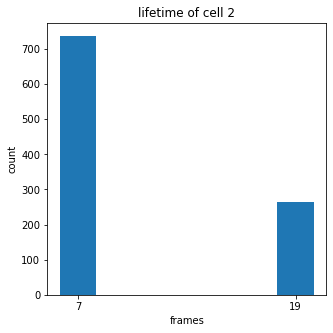

In [195]:
plt.figure(figsize = (5, 5))
plt.title('lifetime of cell 2')
plt.hist(np.array(values), bins = [6, 8, 18, 20])
plt.xticks([7, 19])
plt.xlabel('frames')
plt.ylabel('count')

## method = predict

Frame 19: 2 trajectories present.


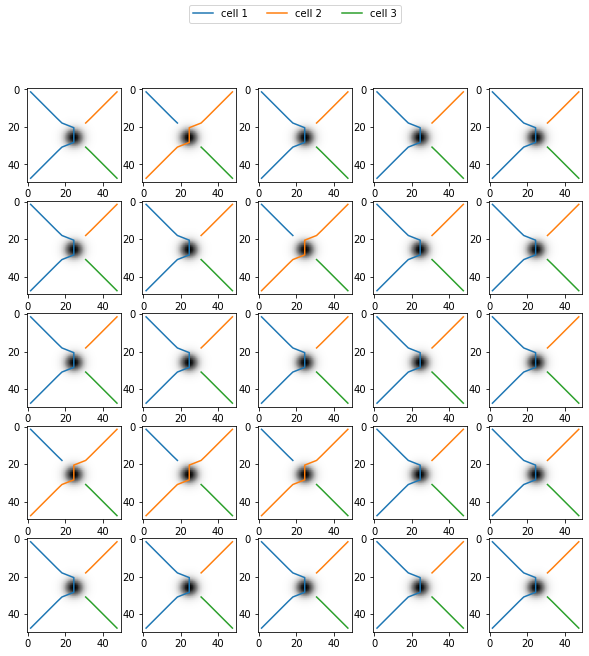

In [196]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))

for j, axes in enumerate(ax.flatten()):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max = 1e3, method_linking='predict')

    axes.imshow(blob[10], cmap = 'Greys')

    for i, track_i in track.groupby('cell'):
        
        if j == 0:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'],
                      label = 'cell {0}'.format(int(i)))
            
        else:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'])
fig.legend(loc='upper center', ncol=3)

In [197]:
values = []
for i in range(1000):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3, 
                                                  method_linking='predict')
    track_mask_2 = track['cell'] == 2

    values.append(track.where(track_mask_2).sortby('frame')['frame'].max())

Frame 19: 2 trajectories present.


Text(0, 0.5, 'count')

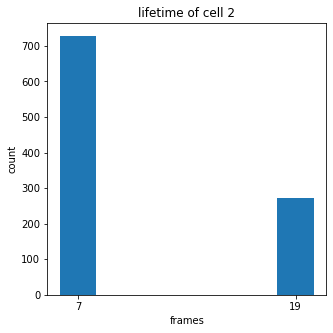

In [198]:
plt.figure(figsize = (5, 5))
plt.title('lifetime of cell 2')
plt.hist(np.array(values), bins = [6, 8, 18, 20])
plt.xticks([7, 19])
plt.xlabel('frames')
plt.ylabel('count')

## memory = 5

Frame 19: 2 trajectories present.


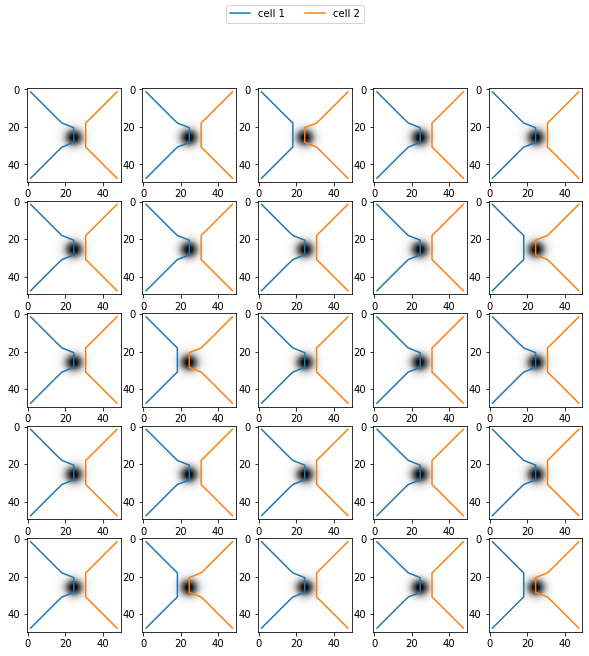

In [199]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))

for j, axes in enumerate(ax.flatten()):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3, 
                                                  memory = 5)

    axes.imshow(blob[10], cmap = 'Greys')

    for i, track_i in track.groupby('cell'):
        
        if j == 0:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'],
                      label = 'cell {0}'.format(int(i)))
            
        else:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'])
fig.legend(loc='upper center', ncol=3)

## adaptive search

Frame 19: 2 trajectories present.


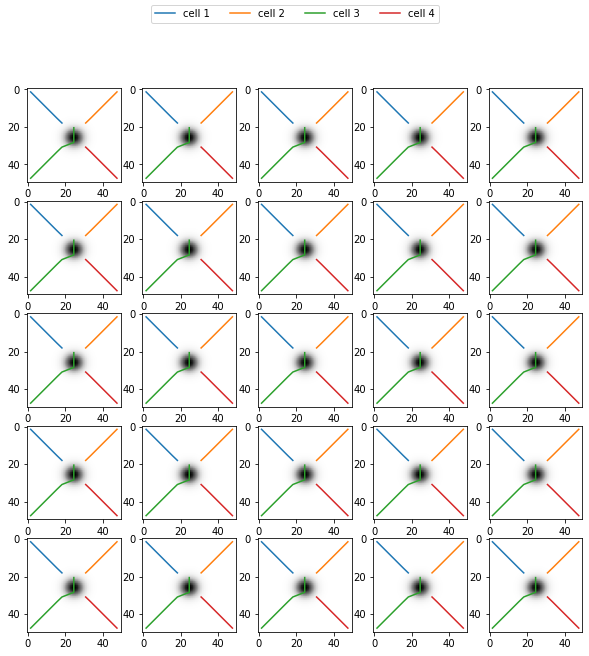

In [203]:
import trackpy as tp
tp.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE = 1

%matplotlib inline
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))

for j, axes in enumerate(ax.flatten()):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3,
                                                  subnetwork_size=1,
                                                  adaptive_stop=1e-2,
                                                  adaptive_step=0.95)

    axes.imshow(blob[10], cmap = 'Greys')

    for i, track_i in track.groupby('cell'):
        
        if j == 0:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'],
                      label = 'cell {0}'.format(int(i)))
            
        else:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'])
fig.legend(loc='upper center', ncol=4)

Frame 19: 2 trajectories present.


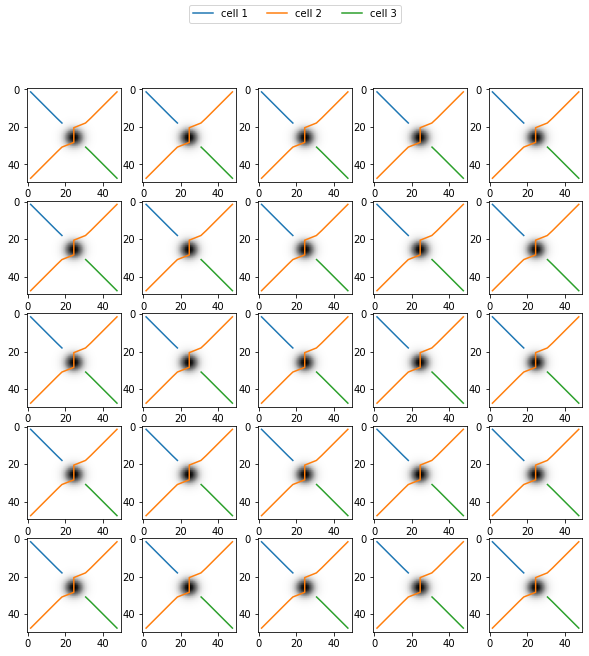

In [183]:
blob = wandering_blob(0, 0, 0, 0, 10, 10, 1, 1, 10) + wandering_blob(10, 0, 0, 0, 10, 10, -1.001, 1, 10)
data = create_xarray(blob)
dxy, dt = tobac.utils.get_spacings(data, grid_spacing = 1)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.5)
mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.5)

%matplotlib inline
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))

for j, axes in enumerate(ax.flatten()):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3, 
                                                  subnetwork_size=2,
                                                  method_linking='random')

    axes.imshow(blob[10], cmap = 'Greys')

    for i, track_i in track.groupby('cell'):
        
        if j == 0:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'],
                      label = 'cell {0}'.format(int(i)))
            
        else:
            axes.plot(track_i.sortby('frame')['hdim_2'], 
                      track_i.sortby('frame')['hdim_1'])
fig.legend(loc='upper center', ncol=3)

In [177]:
values = []
for i in range(200):
    
    track = tobac.themes.tobac_v1.linking_trackpy(features, 
                                                  data, 
                                                  dt, 
                                                  dxy, 
                                                  v_max = 1e3, 
                                                  method_linking='predict')
    track_mask_2 = track['cell'] == 2

    values.append(track.where(track_mask_2).sortby('frame')['frame'].max())

Frame 19: 2 trajectories present.


Text(0, 0.5, 'count')

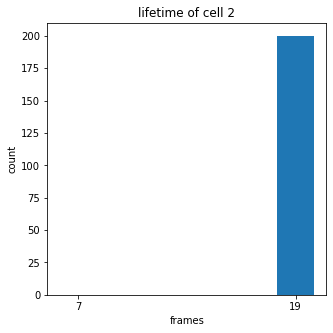

In [178]:
plt.figure(figsize = (5, 5))
plt.title('lifetime of cell 2')
plt.hist(np.array(values), bins = [6, 8, 18, 20])
plt.xticks([7, 19])
plt.xlabel('frames')
plt.ylabel('count')